In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import cv2
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os

In [ ]:

# import each path of the image classes
glaucoma = Path('/content/drive/MyDrive/glaucoma')
cataract = Path('/content/drive/MyDrive/cataract')
normal = Path('/content/drive/MyDrive/normal')
diabetic_retinopathy = Path('/content/drive/MyDrive/diabetic_retinopathy')

In [ ]:

# create a dataframe with the file path and the labels
disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()
from tqdm import tqdm
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/content/drive/MyDrive/diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 2137.30it/s]


In [ ]:

# display the dataframe
df

,image,disease_type
0,/content/drive/MyDrive/glaucoma/_104_9271975.jpg,0
1,/content/drive/MyDrive/glaucoma/_350_3536071.jpg,0
2,/content/drive/MyDrive/glaucoma/_205_310538.jpg,0
3,/content/drive/MyDrive/glaucoma/1482_left.jpg,0
4,/content/drive/MyDrive/glaucoma/_361_5450086.jpg,0
...,...,...
4212,/content/drive/MyDrive/diabetic_retinopathy/11...,3
4213,/content/drive/MyDrive/diabetic_retinopathy/11...,3
4214,/content/drive/MyDrive/diabetic_retinopathy/10...,3
4215,/content/drive/MyDrive/diabetic_retinopathy/10...,3


In [ ]:

# check the count of the target label
df.disease_type.value_counts()

,count
disease_type,
3,1098
2,1074
1,1038
0,1007


In [ ]:

# define function to plot sample images
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

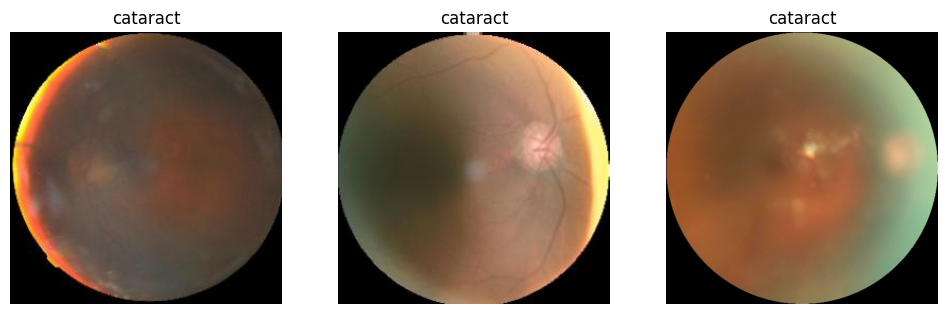

In [ ]:
plot_image(1)

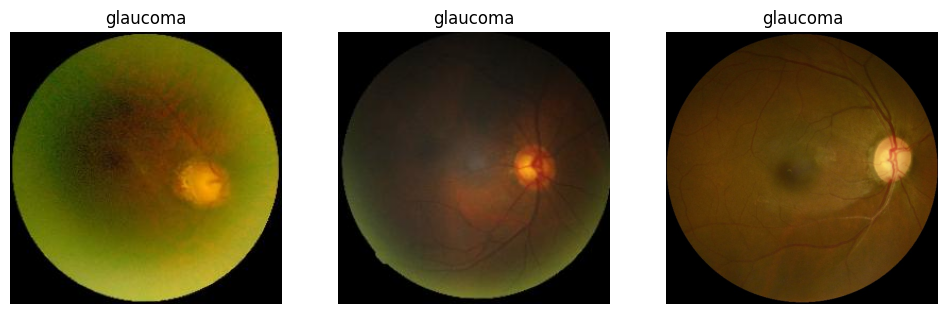

In [ ]:
plot_image(0)

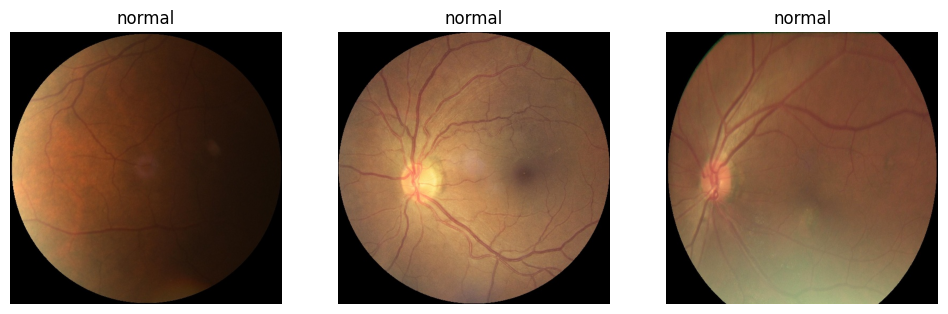

In [ ]:
plot_image(2)

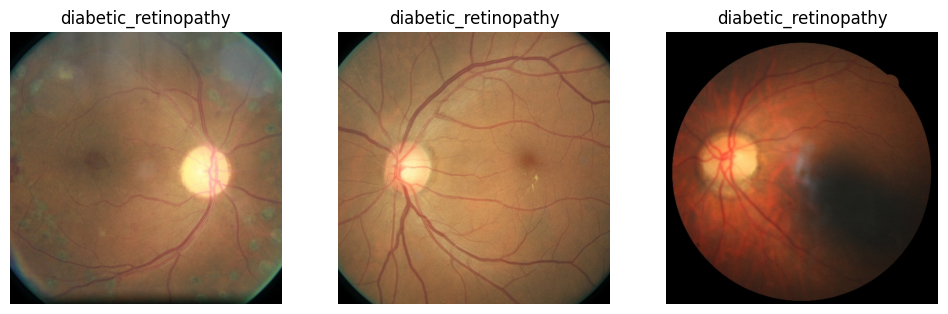

In [ ]:
plot_image(3)

In [ ]:
# map the labels to the disease type
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})


In [ ]:
# check the lebel count to verify it has been mapped
df.disease_type.value_counts()

,count
disease_type,
diabetic_retinopathy,1098
normal,1074
cataract,1038
glaucoma,1007


In [ ]:
# randomising the dataset
df1 = df.sample(frac=1).reset_index(drop=True)

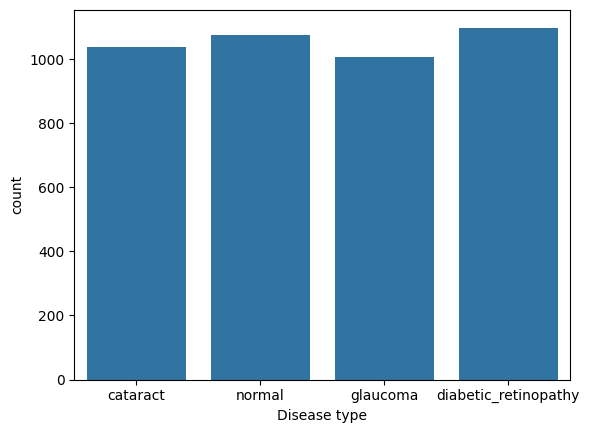

In [ ]:
# create a countplot of the disease type
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()

In [ ]:

#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:

# augumentation of images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [ ]:

# create the train data
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3374 validated image filenames belonging to 4 classes.


In [ ]:

# create the validation data
valid_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 843 validated image filenames belonging to 4 classes.


In [ ]:

labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,446,756 (24.59 MB)

 Trainable params: 6,446,756 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# fitting the model
his = model.fit(
  train_data,
    validation_data=valid_data,
  epochs=5
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 1289s 12s/step - accuracy: 0.5381 - loss: 1.1138 - val_accuracy: 0.7485 - val_loss: 0.6268
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.7873 - loss: 0.5443 - val_accuracy: 0.7711 - val_loss: 0.5361
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.8246 - loss: 0.4561 - val_accuracy: 0.8161 - val_loss: 0.5247
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.8495 - loss: 0.3812 - val_accuracy: 0.8173 - val_loss: 0.4992
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.8704 - loss: 0.3472 - val_accuracy: 0.8019 - val_loss: 0.4879


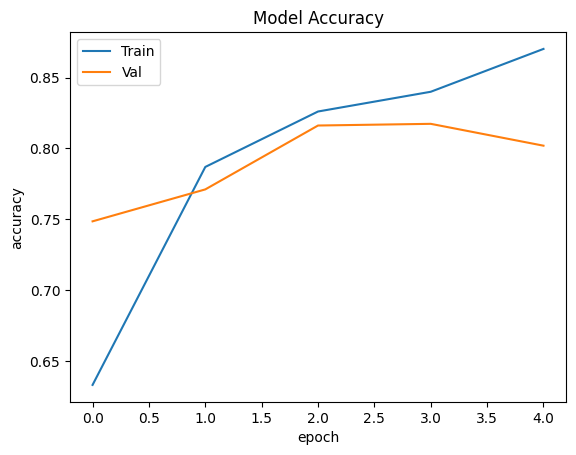

In [ ]:
# create a plot of accuracy and val_acuracy for each epoch
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

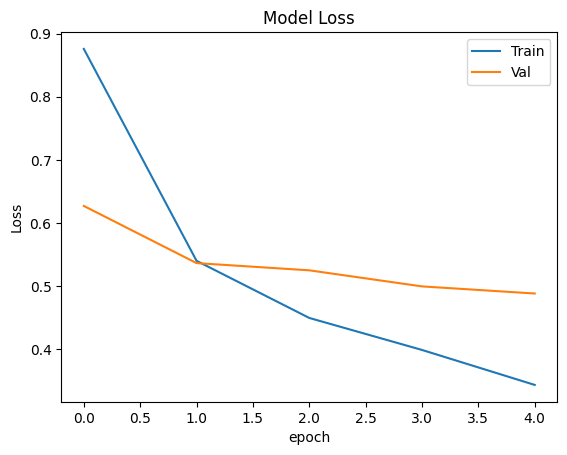

In [51]:

# create a plot of loss and val_loss for each epoch
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [53]:

confmat = ConfusionMatrix(task="multiclass", num_classes=NUMBER_OF_CLASSES)
cm = confmat(preds, targets)


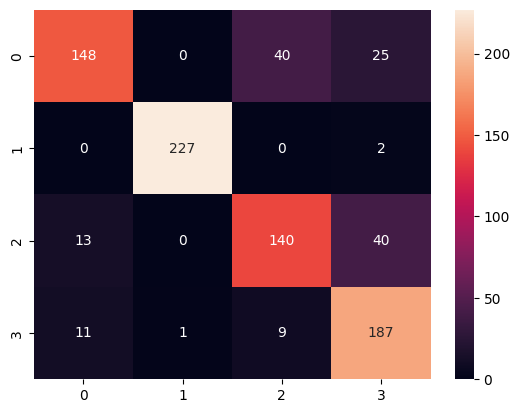

In [63]:



# import seaborn as sns # visualization (already imported)
import matplotlib.pyplot as plt

# ... (other code) ...

# create confusion matrix plot
# sn.heatmap(cm, annot=True, fmt=".0f") # Incorrect - 'sn' is not defined
sns.heatmap(cm, annot=True, fmt=".0f") # Correct - Use 'sns' which is the alias for seaborn
plt.show()

In [55]:
# evaluate the model
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step


In [64]:


# Get predictions and true labels for accuracy calculation
preds = torch.tensor(y_pred)  # Assuming y_pred is a NumPy array
targets = torch.tensor(y_test) # Assuming y_test is a NumPy array

# Assuming you are using a GPU, otherwise change to 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the number of classes (4 in this case)
NUMBER_OF_CLASSES = 4

# Calculate accuracy using torchmetrics
accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")

Accuracy: 80.19%


In [65]:
precision = Precision(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
precision = precision(preds, targets)
print(f"Precision: {100 * precision:.2f}%")

Precision: 80.19%


In [66]:


recall = Recall(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
recall = recall(preds, targets)
print(f"Recall: {100 * recall:.2f}%")

Recall: 80.19%


In [67]:
# generate classification report of the model
print(classification_report(y_test,y_pred,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.72      0.93      0.81       203
diabetic_retinopathy       0.98      1.00      0.99       215
            glaucoma       0.69      0.67      0.68       210
              normal       0.84      0.62      0.71       215

            accuracy                           0.80       843
           macro avg       0.81      0.80      0.80       843
        weighted avg       0.81      0.80      0.80       843



In [68]:
f1 = F1Score(task="multiclass", num_classes=NUMBER_OF_CLASSES)
f1 = f1(preds, targets)
print(f"F1 Score: {100 * f1:.2f}%")


F1 Score: 80.19%
